# Data Cleaning and Prep 

In [1]:
import nltk
import matplotlib
import os
import glob
import nltk, re, pprint
import pandas as pd
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
import mpld3
import gensim 
import pyLDAvis.gensim
import numpy as np

In [2]:
# use glob to get all the files that end with .txt 
textFiles = glob.glob("Books/*txt")
textFiles
type(textFiles)

list

In [12]:
# transform into dictionary so I can have access to books
d = {}
for textFile in textFiles:
    d['f{0}'.format(textFile)] = open(textFile).read()
 
d.keys()

dict_keys(['fBooks/text_38.txt', 'fBooks/text_10.txt', 'fBooks/text_264.txt', 'fBooks/text_270.txt', 'fBooks/text_258.txt', 'fBooks/text_310.txt', 'fBooks/text_304.txt', 'fBooks/text_338.txt', 'fBooks/text_112.txt', 'fBooks/text_106.txt', 'fBooks/text_107.txt', 'fBooks/text_113.txt', 'fBooks/text_339.txt', 'fBooks/text_305.txt', 'fBooks/text_311.txt', 'fBooks/text_259.txt', 'fBooks/text_271.txt', 'fBooks/text_265.txt', 'fBooks/text_11.txt', 'fBooks/text_39.txt', 'fBooks/text_13.txt', 'fBooks/text_273.txt', 'fBooks/text_267.txt', 'fBooks/text_298.txt', 'fBooks/text_307.txt', 'fBooks/text_313.txt', 'fBooks/text_105.txt', 'fBooks/text_111.txt', 'fBooks/text_139.txt', 'fBooks/text_138.txt', 'fBooks/text_110.txt', 'fBooks/text_104.txt', 'fBooks/text_312.txt', 'fBooks/text_306.txt', 'fBooks/text_299.txt', 'fBooks/text_266.txt', 'fBooks/text_272.txt', 'fBooks/text_12.txt', 'fBooks/text_16.txt', 'fBooks/text_276.txt', 'fBooks/text_262.txt', 'fBooks/text_289.txt', 'fBooks/text_302.txt', 'fBooks

In [13]:
# convert the book titles into a list
book_titles = list(d.keys())

# convert values into a list
book_text = list(d.values())

# see first items 
book_text[338][:100]

'Midnight\n\nBeverly Jenkins\n\n\n\n\n\nContents\n\nDedication\n\n\n\nPrologue\n\n\n\nChapter 1\n\n\n\nChapter 2\n\n\n\nChapter'

In [14]:
# transform book titles into a book array to add as a column to a df later
book_array = np.asarray(book_titles)
type(book_array)

numpy.ndarray

## Stopwords, stemming, lemmatizing, and tokenizing 

This section is focused on defining some functions to manipulate the synopses. First, I load NLTK's list of English stop words. Stop words are words like "a", "the", or "in" which don't convey significant meaning. I also append 'towards' as a stopwords, since it appeared as a high frequency item and had to account for spelling (toward vs towards), and 'Chapter'

In [15]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# add towards to the list of stop words 
stopwords.append(['towards', 'Chapter'])

# check the stopwpords were added 
stopwords[-1]

['towards', 'Chapter']

Next I import the Snowball Stemmer and Lemmatizer to get to the root of the word or root meaning.

In [16]:
# load nltk's SnowballStemmer as variable 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# import WordNetLemmatizer as variable 'lemmatizer'
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

Below I define three functions:

* tokenize_and_stem: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
* tokenize_and_lemmatize: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also lemmatizes each token
* tokenize_only: tokenizes the synopsis only

In [17]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


def tokenize_and_lemmatize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lems = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lems

In [18]:
from nltk.tag import pos_tag

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if word.islower() and word.isalpha() and pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

# Filter for only nouns
def noun_only(text):
    pos_comment = nltk.pos_tag(text)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

Here I run the actual text processing (removing of proper nouns, tokenization, removal of stop words)

In [21]:
from gensim import corpora, models, similarities 

#tokenize and lemmatize 
%time tokenized_text = [tokenize_and_lemmatize(text) for text in book_text]

#remove stop words
%time preprocess = [[word for word in text if word not in stopwords] for text in tokenized_text]

# remove proper nouns
%time texts = [strip_proppers_POS(doc) for doc in preprocess]

CPU times: user 9min 10s, sys: 10 s, total: 9min 20s
Wall time: 10min 19s
CPU times: user 53.3 s, sys: 1.79 s, total: 55 s
Wall time: 59.9 s
CPU times: user 18min 26s, sys: 11.2 s, total: 18min 37s
Wall time: 20min 42s


# Latent Diriechlet Allocation Models

## Latent Dirichlet Allocation¶

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the 339 romance novels books. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.

I use Gensim's implementation, and need a dictionary and a corpus that uses bag of words. 

In [22]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

## LDA model: chunking 2000 and topics 20

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [23]:
# increase the chunk size to 2000 
%time lda_mod = models.LdaModel(corpus, num_topics=20,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 37min 56s, sys: 33.7 s, total: 38min 29s
Wall time: 25min 41s


In [24]:
lda_mod.show_topics(20)

[(0,
  '0.011*"mountain" + 0.008*"truck" + 0.008*"wood" + 0.004*"tire" + 0.004*"bus" + 0.004*"station" + 0.004*"iron" + 0.003*"hood" + 0.003*"ol" + 0.003*"redneck"'),
 (1,
  '0.005*"duke" + 0.003*"carriage" + 0.003*"horse" + 0.003*"war" + 0.002*"cousin" + 0.002*"letter" + 0.002*"prince" + 0.002*"slave" + 0.002*"soldier" + 0.002*"servant"'),
 (2,
  '0.004*"cousin" + 0.003*"pregnant" + 0.002*"countered" + 0.002*"extended" + 0.002*"dining" + 0.002*"band" + 0.002*"uncle" + 0.002*"former" + 0.002*"protect" + 0.002*"staircase"'),
 (3,
  '0.005*"movie" + 0.005*"sofa" + 0.004*"police" + 0.004*"camera" + 0.004*"damned" + 0.003*"underneath" + 0.003*"cook" + 0.003*"officer" + 0.003*"parking" + 0.003*"huh"'),
 (4,
  '0.053*"fi" + 0.018*"al" + 0.014*"ed" + 0.013*"e" + 0.012*"fl" + 0.011*"l" + 0.008*"rst" + 0.008*"ing" + 0.008*"stil" + 0.007*"tel"'),
 (5,
  '0.003*"strolled" + 0.002*"shouted" + 0.002*"smirked" + 0.002*"winked" + 0.002*"giggled" + 0.001*"wind" + 0.001*"sank" + 0.001*"rocked" + 0.001*

In [25]:
# Compute Perplexity
print('Perplexity: ', lda_mod.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.211999862835713
Coherence score:  0.42471341406125596


## LDA model: chunking 2000 and topics 25

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [26]:
# increase the topic number to 25
%time lda_mod25 = models.LdaModel(corpus, num_topics=25,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 37min 17s, sys: 20.2 s, total: 37min 37s
Wall time: 23min 34s


In [27]:
lda_mod25.show_topics(25)

[(0,
  '0.003*"sofa" + 0.002*"police" + 0.002*"hospital" + 0.002*"elevator" + 0.002*"client" + 0.002*"weekend" + 0.001*"club" + 0.001*"college" + 0.001*"photo" + 0.001*"computer"'),
 (1,
  '0.020*"shit" + 0.012*"na" + 0.007*"gon" + 0.005*"fuck" + 0.004*"dick" + 0.004*"fucking" + 0.003*"huh" + 0.003*"ta" + 0.003*"wan" + 0.003*"video"'),
 (2,
  '0.024*"church" + 0.022*"mill" + 0.009*"farm" + 0.009*"revival" + 0.007*"fixed" + 0.006*"sir" + 0.006*"education" + 0.005*"peach" + 0.005*"apron" + 0.005*"worker"'),
 (3,
  '0.012*"mom" + 0.009*"dad" + 0.007*"fucking" + 0.007*"shit" + 0.007*"text" + 0.006*"couch" + 0.005*"truck" + 0.004*"weekend" + 0.004*"apartment" + 0.003*"fuck"'),
 (4,
  '0.000*"shit" + 0.000*"fuck" + 0.000*"apartment" + 0.000*"text" + 0.000*"wine" + 0.000*"na" + 0.000*"mom" + 0.000*"couch" + 0.000*"dad" + 0.000*"weekend"'),
 (5,
  '0.000*"shit" + 0.000*"sofa" + 0.000*"fuck" + 0.000*"fucking" + 0.000*"movie" + 0.000*"text" + 0.000*"gon" + 0.000*"weekend" + 0.000*"na" + 0.000*"c

In [28]:
# Compute Perplexity
print('Perplexity: ', lda_mod25.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod25, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.274634261296454
Coherence score:  0.4627567686095665


## LDA model: chunking 2000 and topics 30

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [29]:
# increase the topic number to 30
%time lda_mod30 = models.LdaModel(corpus, num_topics=30,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 38min 4s, sys: 19.6 s, total: 38min 23s
Wall time: 52min 39s


In [30]:
lda_mod30.show_topics(30)

[(0,
  '0.010*"although" + 0.006*"sexual" + 0.005*"pregnant" + 0.005*"cousin" + 0.005*"discovered" + 0.004*"aunt" + 0.004*"affair" + 0.004*"grandfather" + 0.004*"uncle" + 0.004*"beer"'),
 (1,
  '0.000*"fi" + 0.000*"shit" + 0.000*"dad" + 0.000*"apartment" + 0.000*"fucking" + 0.000*"fuck" + 0.000*"cake" + 0.000*"truck" + 0.000*"na" + 0.000*"hospital"'),
 (2,
  '0.002*"despite" + 0.001*"murmured" + 0.001*"tea" + 0.001*"prince" + 0.001*"photo" + 0.001*"project" + 0.001*"jerked" + 0.001*"fingertip" + 0.001*"likely" + 0.001*"muttered"'),
 (3,
  '0.000*"shit" + 0.000*"mom" + 0.000*"fucking" + 0.000*"hospital" + 0.000*"apartment" + 0.000*"pregnant" + 0.000*"na" + 0.000*"cousin" + 0.000*"weekend" + 0.000*"text"'),
 (4,
  '0.000*"shit" + 0.000*"fuck" + 0.000*"text" + 0.000*"couch" + 0.000*"na" + 0.000*"apartment" + 0.000*"hospital" + 0.000*"police" + 0.000*"college" + 0.000*"partner"'),
 (5,
  '0.012*"cake" + 0.011*"weekend" + 0.011*"text" + 0.009*"couch" + 0.008*"cupcake" + 0.006*"elevator" + 0

In [31]:
# Compute Perplexity
print('Perplexity: ', lda_mod30.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod30, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.359900223339398
Coherence score:  0.3910419326242234


## LDA model: chunking 2000 and topics 35

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [32]:
# increase the topic number to 35
%time lda_mod35 = models.LdaModel(corpus, num_topics=35,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 1h 5min 12s, sys: 44.7 s, total: 1h 5min 57s
Wall time: 33min 48s


In [33]:
lda_mod35.show_topics(35)

[(0,
  '0.011*"asks" + 0.005*"lean" + 0.003*"lift" + 0.003*"shit" + 0.003*"shrug" + 0.003*"na" + 0.003*"slide" + 0.002*"squeeze" + 0.002*"gon" + 0.002*"snap"'),
 (1,
  '0.004*"strolled" + 0.002*"shouted" + 0.002*"smirked" + 0.002*"winked" + 0.002*"wind" + 0.002*"giggled" + 0.002*"sank" + 0.001*"elevator" + 0.001*"eyed" + 0.001*"rocked"'),
 (2,
  '0.004*"pressroom" + 0.004*"dolyn" + 0.002*"gawky" + 0.002*"oored" + 0.002*"exclaim" + 0.001*"suckles" + 0.001*"superstardom" + 0.000*"macchiato" + 0.000*"sportscaster" + 0.000*"audition"'),
 (3,
  '0.004*"sofa" + 0.003*"police" + 0.002*"hospital" + 0.002*"movie" + 0.002*"elevator" + 0.002*"parking" + 0.002*"player" + 0.002*"lawyer" + 0.002*"reporter" + 0.001*"client"'),
 (4,
  '0.007*"although" + 0.004*"sexual" + 0.004*"discovered" + 0.003*"pregnant" + 0.003*"cousin" + 0.003*"affair" + 0.003*"aunt" + 0.003*"grandfather" + 0.003*"uncle" + 0.003*"hospital"'),
 (5,
  '0.000*"gon" + 0.000*"shit" + 0.000*"fuck" + 0.000*"na" + 0.000*"dick" + 0.000*"

In [34]:
# Compute Perplexity
print('Perplexity: ', lda_mod35.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod35, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.468474360076442
Coherence score:  0.4333991983247065


## LDA model: chunking 2000 and topics 40

Chunking to 2000 instead of 1000 or 2500 gives me better perplexity and coherence score 

In [35]:
# increase the topic number to 40
%time lda_mod40 = models.LdaModel(corpus, num_topics=40,id2word=dictionary, update_every=5, chunksize=2000, passes=100)

CPU times: user 1h 18min 57s, sys: 22.8 s, total: 1h 19min 20s
Wall time: 40min 1s


In [36]:
lda_mod40.show_topics(40)

[(0,
  '0.006*"cock" + 0.005*"murmured" + 0.004*"pussy" + 0.003*"lust" + 0.003*"jerked" + 0.002*"harsh" + 0.002*"muttered" + 0.002*"clit" + 0.002*"fuck" + 0.002*"caress"'),
 (1,
  '0.008*"snow" + 0.006*"cat" + 0.005*"realise" + 0.004*"realised" + 0.004*"blizzard" + 0.004*"gin" + 0.003*"occurred" + 0.003*"affection" + 0.003*"kitten" + 0.003*"fucking"'),
 (2,
  '0.020*"yarn" + 0.014*"knitting" + 0.005*"damned" + 0.005*"practically" + 0.005*"hat" + 0.005*"knit" + 0.005*"neighborhood" + 0.004*"sandwich" + 0.004*"wing" + 0.004*"community"'),
 (3,
  '0.000*"shit" + 0.000*"text" + 0.000*"weekend" + 0.000*"mom" + 0.000*"club" + 0.000*"na" + 0.000*"stage" + 0.000*"movie" + 0.000*"fuck" + 0.000*"college"'),
 (4,
  '0.006*"royal" + 0.005*"prince" + 0.005*"sword" + 0.005*"perhaps" + 0.004*"photo" + 0.004*"train" + 0.004*"despite" + 0.004*"palace" + 0.003*"tea" + 0.003*"fingertip"'),
 (5,
  '0.005*"sofa" + 0.004*"towards" + 0.003*"trouser" + 0.003*"although" + 0.003*"lift" + 0.003*"tugged" + 0.003*

In [37]:
# Compute Perplexity
print('Perplexity: ', lda_mod40.log_perplexity(corpus)) 

# compute coherence
cm = gensim.models.coherencemodel.CoherenceModel(
         model=lda_mod40, texts=texts,
         dictionary=dictionary, coherence='c_v')   
                                                
print('Coherence score: ', cm.get_coherence())

Perplexity:  -9.511247449989954
Coherence score:  0.4113920630744191


# Note: After this section I'll be using only one model to run the matrices, LDA vis, and book similarity calculations.

# Topic Matrices

### Model with 20 topics

In [38]:
topics_matrix = lda_mod40.show_topics(formatted=False, num_words=100)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('na', 2.394089e-05)", "('fuck', 2.3940864e-05)", "('gon', 2.3940831e-05)", "('hospital', 2.3940815e-05)", "('apartment', 2.3940813e-05)", "('shit', 2.394081e-05)", "('text', 2.394079e-05)", "('fucking', 2.3940785e-05)", "('mom', 2.3940784e-05)", "('weekend', 2.3940784e-05)", "('cousin', 2.3940784e-05)", "('couch', 2.3940778e-05)", "('sofa', 2.3940778e-05)", "('beer', 2.3940771e-05)", "('club', 2.3940767e-05)", "('grandmother', 2.3940765e-05)", "('pregnant', 2.3940765e-05)", "('tea', 2.3940758e-05)", "('dog', 2.3940756e-05)", "('police', 2.3940756e-05)", "('porch', 2.3940755e-05)", "('elevator', 2.394075e-05)", "('gun', 2.3940744e-05)", "('muttered', 2.3940742e-05)", "('field', 2.3940742e-05)", "('protect', 2.394074e-05)", "('movie', 2.394074e-05)", "('land', 2.3940738e-05)", "('nurse', 2.3940738e-05)", "('computer', 2.3940736e-05)", "('although', 2.3940736e-05)", "('fi', 2.3940736e-05)", "('stage', 2.3940736e-05)", "('song', 2.3940736e-05)", "('studied', 2.3940736e-05)", "('dick', 2

# Visualizing and Interpreting Topics

### Topics with 20 models

In [287]:
# visualize topics 
import pyLDAvis.gensim 

pyLDAvis.enable_notebook()
lda_visualization = pyLDAvis.gensim.prepare(lda_mod, corpus, dictionary, sort_topics=False, mds='pcoa')

In [289]:
pyLDAvis.display(lda_visualization)

# Heatmap comparing book topics

Source/inspo: https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

In [40]:
# get topics for every book 
topics = [lda_mod40[corpus[i]] for i in range(len(book_text))]

# define function to get the topics into a df 
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(40))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

# test function 
topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=20) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000000,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.0,0.0,0.205854,0.0,0.000000,0.0,0,0.0,0,0
1,0.030142,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.0,0.0,0.421597,0.0,0.000000,0.0,0,0.0,0,0
2,0.012073,0.0,0.0,0,0.0,0.035828,0.000000,0.0,0.0,0,...,0.0,0.0,0.215852,0.0,0.000000,0.0,0,0.0,0,0
3,0.031436,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.0,0.0,0.669520,0.0,0.000000,0.0,0,0.0,0,0
4,0.026584,0.0,0.0,0,0.0,0.000000,0.022054,0.0,0.0,0,...,0.0,0.0,0.426919,0.0,0.013468,0.0,0,0.0,0,0


### Visualize the topics in each book

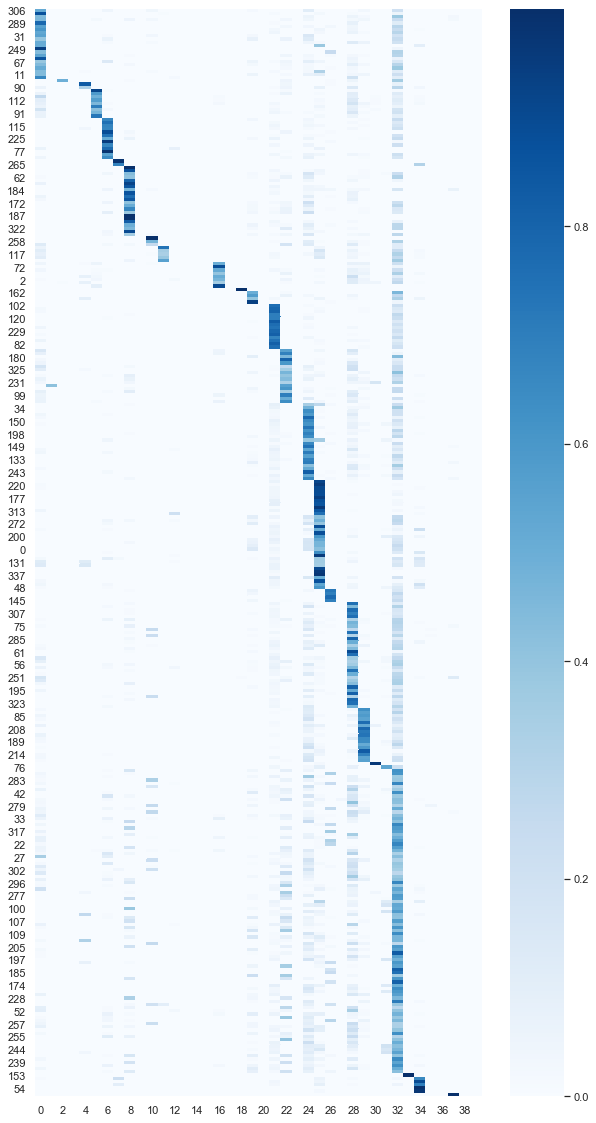

In [42]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index], cmap = 'Blues')

In [43]:
document_topic2 = document_topic

In [44]:
document_topic.sort_values(14, ascending=False)[14].head(5)

0      0
223    0
231    0
230    0
229    0
Name: 14, dtype: int64

In [45]:
# define function to get the numbers from rows with strings 
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

In [46]:
document_topic['standard_title'] = book_array

document_topic['book_title_number'] = document_topic['standard_title'].apply(lambda x: find_number(x))

document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,standard_title,book_title_number
0,0.000000,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.205854,0.0,0.000000,0.0,0,0.0,0,0,fBooks/text_38.txt,38
1,0.030142,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.421597,0.0,0.000000,0.0,0,0.0,0,0,fBooks/text_10.txt,10
2,0.012073,0.0,0.0,0,0.0,0.035828,0.000000,0.0,0.0,0,...,0.215852,0.0,0.000000,0.0,0,0.0,0,0,fBooks/text_264.txt,264
3,0.031436,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.669520,0.0,0.000000,0.0,0,0.0,0,0,fBooks/text_270.txt,270
4,0.026584,0.0,0.0,0,0.0,0.000000,0.022054,0.0,0.0,0,...,0.426919,0.0,0.013468,0.0,0,0.0,0,0,fBooks/text_258.txt,258


In [47]:
# read csv file with the book metadata 
book_metadata = pd.read_csv('List of Authors - Books.csv')

#book_metadata = book_metadata.set_index('file_number')

book_metadata['book_title_number'] = book_metadata['file_number'].apply(str)

book_metadata.head()

,Author,Book,file_number,Filename,Year published,Number of pages,book_title_number
0,Alyssa Cole,A duke by default,1,text_1.txt,2018.0,385.0,1
1,Alyssa Cole,A hope divided,2,text_2.txt,2017.0,349.0,2
2,Alyssa Cole,A prince on paper,3,text_3.txt,2019.0,335.0,3
3,Alyssa Cole,A princess in theory,4,text_4.txt,2018.0,221.0,4
4,Alyssa Cole,An extraordinary union,5,text_5.txt,2017.0,292.0,5


In [48]:
book_df = document_topic.merge(book_metadata, how='outer', right_on = 'book_title_number', left_on = 'book_title_number')

book_df = book_df.set_index('Book')

book_df.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,standard_title,book_title_number,Author,file_number,Filename,Year published,Number of pages
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a new day,0.000000,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.0,0,0,fBooks/text_38.txt,38,Beverly Jenkins,38,NaN,2016.0,152.0
Her lovers legacy,0.030142,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.0,0,0,fBooks/text_10.txt,10,Adrianne Byrd,10,text_10.txt,2008.0,249.0
Island fling,0.012073,0.0,0.0,0,0.0,0.035828,0.000000,0.0,0.0,0,...,0.0,0,0,fBooks/text_264.txt,264,Therese Beharrie,264,NaN,NaN,NaN
The kingmaker,0.031436,0.0,0.0,0,0.0,0.000000,0.000000,0.0,0.0,0,...,0.0,0,0,fBooks/text_270.txt,270,Kennedy Ryan,270,NaN,NaN,NaN
The write escape,0.026584,0.0,0.0,0,0.0,0.000000,0.022054,0.0,0.0,0,...,0.0,0,0,fBooks/text_258.txt,258,Charish Reid,258,NaN,NaN,NaN


In [49]:
book_viz = book_df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                    22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 'Author']]

book_viz

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,38,39,Author
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a new day,0.000000,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.000000,0,...,0.000000,0.000000,0.205854,0.0,0.000000,0.0,0,0,0,Beverly Jenkins
Her lovers legacy,0.030142,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.000000,0,...,0.000000,0.000000,0.421597,0.0,0.000000,0.0,0,0,0,Adrianne Byrd
Island fling,0.012073,0.0,0.0,0,0.000000,0.035828,0.000000,0.0,0.000000,0,...,0.000000,0.000000,0.215852,0.0,0.000000,0.0,0,0,0,Therese Beharrie
The kingmaker,0.031436,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.000000,0,...,0.000000,0.000000,0.669520,0.0,0.000000,0.0,0,0,0,Kennedy Ryan
The write escape,0.026584,0.0,0.0,0,0.000000,0.000000,0.022054,0.0,0.000000,0,...,0.000000,0.000000,0.426919,0.0,0.013468,0.0,0,0,0,Charish Reid
Higher love,0.000000,0.0,0.0,0,0.000000,0.000000,0.010125,0.0,0.248956,0,...,0.000000,0.000000,0.418654,0.0,0.000000,0.0,0,0,0,Alexandria House
Go deep,0.087610,0.0,0.0,0,0.000000,0.000000,0.016727,0.0,0.107077,0,...,0.000000,0.000000,0.254054,0.0,0.000000,0.0,0,0,0,Rilzy Adams
The sweetest surrender,0.000000,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.029376,0,...,0.000000,0.000000,0.128024,0.0,0.000000,0.0,0,0,0,Stephanie Nicole Norris
His diamond queen,0.449026,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.027877,0,...,0.000000,0.000000,0.294377,0.0,0.000000,0.0,0,0,0,Lena Hart


In [50]:
book_viz['max_val'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                17, 18, 19, 20, 21,22, 23, 24, 25, 26, 27, 28, 29, 
                                30, 31, 32, 33, 34, 35, 36, 38, 39]].max(axis=1)
book_viz['max_col'] = book_viz[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
                                31, 32, 33, 34, 35, 36, 38, 39]].idxmax(axis=1)

#document_topic['second_largest'] = document_topic.apply(lambda row: row.nlargest(2).values[-1],axis=1)
book_viz

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,38,39,Author,max_val,max_col
Book,,,,,,,,,,,,,,,,,,,,,
Stepping to a new day,0.000000,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.000000,0,...,0.205854,0.0,0.000000,0.0,0,0,0,Beverly Jenkins,0.423634,25
Her lovers legacy,0.030142,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.000000,0,...,0.421597,0.0,0.000000,0.0,0,0,0,Adrianne Byrd,0.421597,32
Island fling,0.012073,0.0,0.0,0,0.000000,0.035828,0.000000,0.0,0.000000,0,...,0.215852,0.0,0.000000,0.0,0,0,0,Therese Beharrie,0.471714,16
The kingmaker,0.031436,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.000000,0,...,0.669520,0.0,0.000000,0.0,0,0,0,Kennedy Ryan,0.669520,32
The write escape,0.026584,0.0,0.0,0,0.000000,0.000000,0.022054,0.0,0.000000,0,...,0.426919,0.0,0.013468,0.0,0,0,0,Charish Reid,0.426919,32
Higher love,0.000000,0.0,0.0,0,0.000000,0.000000,0.010125,0.0,0.248956,0,...,0.418654,0.0,0.000000,0.0,0,0,0,Alexandria House,0.418654,32
Go deep,0.087610,0.0,0.0,0,0.000000,0.000000,0.016727,0.0,0.107077,0,...,0.254054,0.0,0.000000,0.0,0,0,0,Rilzy Adams,0.353706,22
The sweetest surrender,0.000000,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.029376,0,...,0.128024,0.0,0.000000,0.0,0,0,0,Stephanie Nicole Norris,0.778340,28
His diamond queen,0.449026,0.0,0.0,0,0.000000,0.000000,0.000000,0.0,0.027877,0,...,0.294377,0.0,0.000000,0.0,0,0,0,Lena Hart,0.449026,0


In [53]:
bookData = book_viz.reset_index()
bookData = bookData.reset_index()

bookData.head()

,index,Book,0,1,2,3,4,5,6,7,...,32,33,34,35,36,38,39,Author,max_val,max_col
0,0,Stepping to a new day,0.000000,0.0,0.0,0,0.0,0.000000,0.000000,0.0,...,0.205854,0.0,0.000000,0.0,0,0,0,Beverly Jenkins,0.423634,25
1,1,Her lovers legacy,0.030142,0.0,0.0,0,0.0,0.000000,0.000000,0.0,...,0.421597,0.0,0.000000,0.0,0,0,0,Adrianne Byrd,0.421597,32
2,2,Island fling,0.012073,0.0,0.0,0,0.0,0.035828,0.000000,0.0,...,0.215852,0.0,0.000000,0.0,0,0,0,Therese Beharrie,0.471714,16
3,3,The kingmaker,0.031436,0.0,0.0,0,0.0,0.000000,0.000000,0.0,...,0.669520,0.0,0.000000,0.0,0,0,0,Kennedy Ryan,0.669520,32
4,4,The write escape,0.026584,0.0,0.0,0,0.0,0.000000,0.022054,0.0,...,0.426919,0.0,0.013468,0.0,0,0,0,Charish Reid,0.426919,32


# Book recommendation based on LDA

In [55]:
import itertools 

# define functions 
bookList = bookData['Book']
bookIndex = bookData['index']
bookAuthor = bookData['Author']
index2 = similarities.MatrixSimilarity(lda_mod[corpus])


#userSelection = 6
userSelection = input("Hey, please enter the book you would like to find similar books for: ")

#listOfRelatedBooks = []
corpus_to_compare = []
names_of_related_books = []
identifiedTopic = 55

for book in range(1, 339):
    if userSelection == bookList[book]:
          corpusA = corpus[bookIndex[book]]
          vec_lda = lda_mod[corpusA]
          corpus_to_compare.append(vec_lda)

sim = index2[vec_lda]
sims = sorted(enumerate(sim), key=lambda item: -item[1])
DoublelistOfRelatedBooks = [list(group) for val, group in itertools.groupby(sims, lambda x: x[1] >= .97) if val]
listOfRelatedBooks = DoublelistOfRelatedBooks[0]

# split tuples into two lists with book name and similarity score 
book_name, score = map(list, zip(*listOfRelatedBooks))

# iterate to get the name of the books and not the book index 
for book in book_name:
     if (bookIndex[book]== book_name).any():
        names_of_related_books.append(bookList[book])
        names_of_related_books.append(' by ' + str(bookAuthor[book]) + '\n')

print("Here's your list:" + '\n' + ''.join(names_of_related_books) + ' ')

print('Happy reading!')


Hey, please enter the book you would like to find similar books for: Get a life, Chloe Brown 
Here's your list:
Get a life, Chloe Brown  by Talia Hibbert
Take a hint, Dani Brown  by Talia Hibbert
Sin and ink by Naima Simone
 
Happy reading!


# Model using Mallet

So far I've been using Gensim to get the topics. In this section I use Mallet to compare results.

In [295]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = '/Users/vclugoar/new_mallet/mallet-2.0.8/'

mallet_path = '/Users/vclugoar/new_mallet/mallet-2.0.8/bin/mallet'

print ("Hello")

mallet_lda = gensim.models.wrappers.ldamallet.LdaMallet(mallet_path, corpus, dictionary, optimize_interval=10, prefix = 'm_')

Hello


CalledProcessError: Command '/Users/vclugoar/new_mallet/mallet-2.0.8/bin/mallet train-topics --input m_corpus.mallet --num-topics Dictionary(41770 unique tokens: ['abandoned', 'abhor', 'ability', 'abject', 'abuela']...)  --alpha 50 --optimize-interval 10 --num-threads 4 --output-state m_state.mallet.gz --output-doc-topics m_doctopics.txt --output-topic-keys m_topickeys.txt --num-iterations 1000 --inferencer-filename m_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0' returned non-zero exit status 2.

In [167]:
mallet_topics = mallet_lda.show_topics(20)

NameError: name 'mallet_lda' is not defined